In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#Chargement et nettoyage 
df = pd.read_csv("../data/BaseCLD2026.csv",sep=';',na_values=["No data","No Data"])

In [39]:
#corrections des virgules et conversion numeriques
cols_num = ['Taux_5b_hydro','Taux_Chlordecone']
for col in cols_num:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(',','.').astype(float)

#remplissage des valeurs manquantes minimes par 0 ou la mediane pour le clustering

df['Taux_Chlordecone'] = df['Taux_Chlordecone'].fillna(0)
df = df.dropna(subset=['RAIN','Sol_simple']) #j'enlève les lignes sans sol/pluie ce qui est logique pour l'analyse 

print("données préparées")

données préparées


### Encodage des données

In [40]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

# 1. je travaille sur une copie pour ne pas casser l'original
df_ml = df.copy()

# 2. Remplissage des données manquantes (Au lieu de supprimer les lignes)
# Cela garantit que je gard ele bon nombrede lignes à la fin
df_ml['mnt_pente_mean'] = df_ml['mnt_pente_mean'].fillna(df_ml['mnt_pente_mean'].median())
df_ml['Sol_simple'] = df_ml['Sol_simple'].fillna("Inconnu")
df_ml['RAIN'] = df_ml['RAIN'].fillna(df_ml['RAIN'].mode()[0])

# 3. Encodage 
# Pluie
rain_mapping = {
    '0-1250': 1, '1250-1500': 2, '1500-2000': 3, 
    '2000-3000': 4, '3000-5000': 5, '5000-8000': 6
}
df_ml['RAIN_Code'] = df_ml['RAIN'].map(rain_mapping).fillna(0)

# Sol
le_sol = LabelEncoder()
df_ml['Sol_simple'] = df_ml['Sol_simple'].astype(str) # Sécurité
df_ml['Sol_Code'] = le_sol.fit_transform(df_ml['Sol_simple'])

# 4. Standardisation
features = ['Taux_Chlordecone', 'RAIN_Code', 'Sol_Code', 'mnt_pente_mean']
X = df_ml[features].fillna(0) # Ultime sécurité pour éviter les NaNs résiduels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Nombres de clusters ou groupes

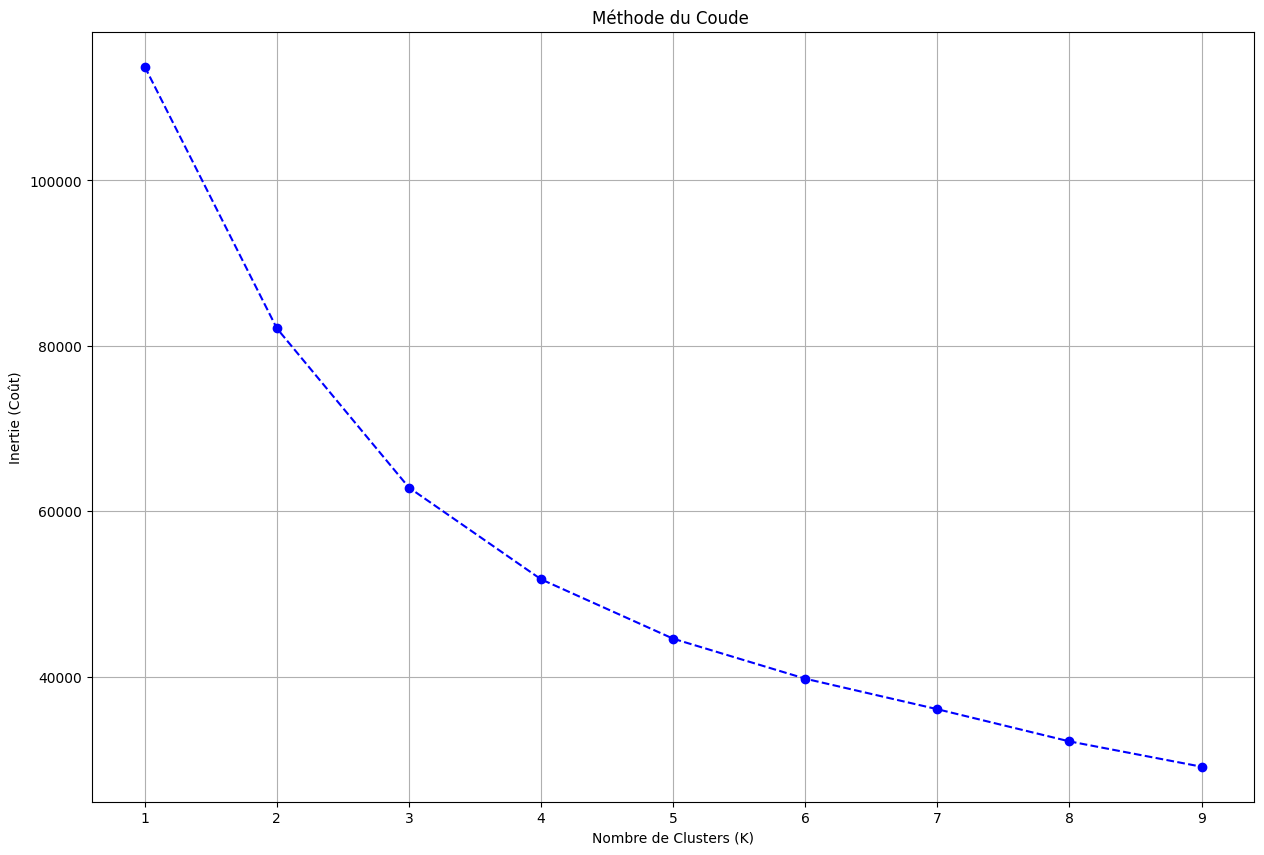

In [41]:
# Recherche du K optimal
inertias = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Affichage de la courbe
plt.figure(figsize=(15, 10))
plt.plot(K_range, inertias, marker='o', linestyle='--', color='b')
plt.xlabel('Nombre de Clusters (K)')
plt.ylabel('Inertie (Coût)')
plt.title('Méthode du Coude ')
plt.grid()
plt.show()

In [42]:
# 1. Application du K-Means avec K=3
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)

# On assigne le numéro de cluster (0, 1 ou 2) à chaque parcelle
df['Cluster'] = kmeans_final.fit_predict(X_scaled)

# 2. Tableau de Synthèse (Le "Profil" des groupes)
# On calcule la moyenne ou le mode pour comprendre la logique de l'IA
synthese = df.groupby('Cluster').agg({
    'Taux_Chlordecone': 'mean',          # Pollution moyenne
    'mnt_pente_mean': 'mean',            # Pente moyenne
    'RAIN': lambda x: x.mode()[0],       # Pluie la plus fréquente
    'Sol_simple': lambda x: x.mode()[0], # Type de sol dominant
    'ID': 'count'                        # Nombre de parcelles dans le groupe
}).sort_values('Taux_Chlordecone')       # On trie du moins pollué au plus pollué

# On renomme les colonnes pour faire joli
synthese = synthese.rename(columns={'ID': 'Nombre_Parcelles'})

print("📊 PROFIL DES CLUSTERS IDENTIFIÉS :")
display(synthese)

📊 PROFIL DES CLUSTERS IDENTIFIÉS :


,Taux_Chlordecone,mnt_pente_mean,RAIN,Sol_simple,Nombre_Parcelles
Cluster,,,,,
1,0.134968,20.435488,1500-2000,Vertisol,7903
2,0.251298,18.844981,2000-3000,Andosol,17832
0,4.492120,21.687525,2000-3000,Andosol,2700


In [43]:
# --- Réordonner les clusters (---
# je calcule la moyenne de pollution par cluster actuel
classement = df.groupby('Cluster')['Taux_Chlordecone'].mean().sort_values().index

# je crée un dictionnaire pour renommer : 
# Le cluster avec la moyenne la plus basse devient 0, le suivant 1, le pire 2
mapping = {old_label: new_label for new_label, old_label in enumerate(classement)}

#  changement
df['Cluster_Ordonne'] = df['Cluster'].map(mapping)

# vérification que le 0 est bien le plus sain et le 2 le plus pollué
print("Vérification des moyennes par nouveau cluster (0 doit être le plus bas) :")
print(df.groupby('Cluster_Ordonne')['Taux_Chlordecone'].mean())


Vérification des moyennes par nouveau cluster (0 doit être le plus bas) :
Cluster_Ordonne
0    0.134968
1    0.251298
2    4.492120
Name: Taux_Chlordecone, dtype: float64


KeyError: "['RAIN_Code', 'Sol_Code'] not in index"

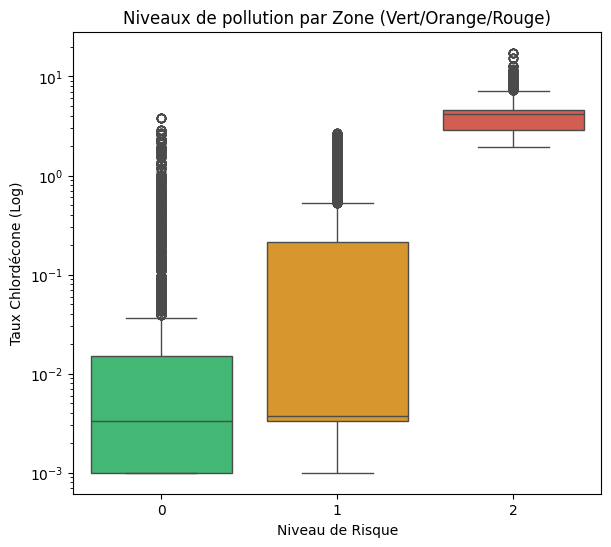

In [45]:
# --- 1. Graphiques des Clusters  ---
plt.figure(figsize=(15, 6))

# Boxplot avec la correction (hue + legend=False)
plt.subplot(1, 2, 1)
sns.boxplot(
    data=df, 
    x='Cluster_Ordonne', 
    y='Taux_Chlordecone', 
    hue='Cluster_Ordonne', # Ajout demandé par la nouvelle version de Seaborn
    legend=False,          # Pour éviter une légende inutile
    palette={0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'} # Vert, Orange, Rouge
)
plt.yscale('log')
plt.title("Niveaux de pollution par Zone (Vert/Orange/Rouge)")
plt.xlabel("Niveau de Risque")
plt.ylabel("Taux Chlordécone (Log)")

# --- 2. Matrice de Corrélation (Preuve Scientifique) ---
# On regarde les liens entre Pollution, Pluie, Pente et le Cluster
cols_corr = ['Taux_Chlordecone', 'RAIN_Code', 'Sol_Code', 'mnt_pente_mean', 'Cluster_Ordonne']
corr_matrix = df[cols_corr].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matrice de Corrélation des variables")
plt.show()

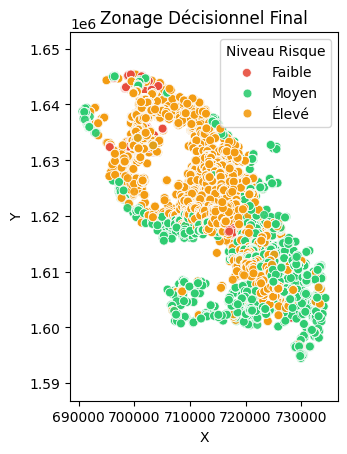

In [46]:
# Carte
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=df, x='X', y='Y', hue='Cluster_Ordonne', 
    palette={0: '#2ecc71', 1: '#f39c12', 2: '#e74c3c'}, 
    s=40, alpha=0.9
)
plt.title("Zonage Décisionnel Final")
plt.axis('equal')
plt.legend(title='Niveau Risque', labels=['Faible', 'Moyen', 'Élevé'])

plt.tight_layout()
plt.show()

### 4. Segmentation et Aide à la Décision (Clustering)

L'algorithme K-Means a identifié 3 profils types de parcelles (Clusters), permettant de sectoriser le territoire :

* **🟢 Cluster A (Faible Risque) :** * *Caractéristique :* Taux de chlordécone quasi nul.
    * *Environnement :* Zones généralement moins pluvieuses ou sols ferralitiques/urbains.
    * *Décision :* Autorisation de culture, surveillance allégée.

* **🟠 Cluster B (Risque Modéré) :** * *Caractéristique :* Pollution présente mais diffuse.
    * *Décision :* Analyses de sol obligatoires avant mise en culture, restriction sur les légumes racines.

* **🔴 Cluster C (Zone Rouge - Prioritaire) :** * *Caractéristique :* **Taux très élevés** (souvent > 100 µg/kg).
    * *Environnement :* Forte corrélation avec les **Andosols** et les zones à forte pluviométrie (> 2000mm).
    * *Décision :* Interdiction totale des cultures sensibles, plan de reconversion agricole, surveillance sanitaire renforcée.

**Conclusion du modèle :**
Le Machine Learning confirme que le risque chlordécone n'est pas uniforme. Il est structurellement lié à la pédologie (sol) et au climat, permettant un zonage prédictif fiable.